# DTSA 5509 Final Project: EDA and Prediction of Stroke Data

For my project I have chosen to analyze a [stroke dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) provided by kaggle. The dataset contains 5110 observations (patients) with 12 attributes, including a binary classification for whether they did or didn't have a stroke. The original source of the data is described as "confidential", and any attributes that might be used to personally identify a patient have been omitted (e.g. name and location). 

### Goal and Motivation
The goal of this project is to develop models capable of accurately predicting which patients are at risk of strokes using the available dataset. This will require cleaning and preprocessing of the data followed by model selection, evaluation, and optimization.

All code and data for this project is available on my GitHub (https://github.com/nhansendev/DTSA5509_Final).

### Setup and Cleaning
The first step is to import the required libraries:

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn.impute import KNNImputer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay

# Most custom functions have been moved to a separate file
from functions import (
    categorical_to_columns, 
    standardize_columns, 
    inspect_df, 
    categorical_to_numeric, 
    pair_plot, 
    GridSearch, 
    PCA_plot, 
    model_ensembles,
    plot_ensembles,
)

SCRIPT_DIR = os.getcwd()
RANDOM_SEED = 1

# pd.set_option('display.width', 1000)
# pd.set_option('display.max_rows', 100)

Loading the dataset and some initial inspection of the data:

In [2]:
# Assume data is in the same folder as the script
dataset = pd.read_csv(os.path.join(SCRIPT_DIR, "stroke_data.csv"))

print('> Pre Cleaning')
inspect_df(dataset)

> Pre Cleaning
id               : 67.000 to 72940.000
gender           : ['Female', 'Male', 'Other'], [2994, 2115, 1]
age              : 0.080 to 82.000
hypertension     : 0.000 to 1.000
heart_disease    : 0.000 to 1.000
ever_married     : ['No', 'Yes'], [1757, 3353]
work_type        : ['Govt_job', 'Never_worked', 'Private', 'Self-employed', 'children'], [657, 22, 2925, 819, 687]
Residence_type   : ['Rural', 'Urban'], [2514, 2596]
avg_glucose_level: 55.120 to 271.740
bmi              : nan to nan
smoking_status   : ['Unknown', 'formerly smoked', 'never smoked', 'smokes'], [1544, 885, 1892, 789]
stroke           : 0.000 to 1.000


Actions for cleaning the dataset:
1. The 'id' column only identifies patients, which is not useful for prediction/clustering, so it can be dropped. 
2. It's clear that there is only one instance of "Other" for gender, with the rest being "Male" or "Female", so it seems safe to drop the "Other" instance. 
3. Categorical values like work type can be converted to n-1 one-hot encoded columns, or numeric values (easier to visualize).
4. BMI has missing (nan) values, which can be imputed via KNN.
5. Standardization, since some algorithems may produce better results with, or require standardized data

In [3]:
dataset.drop(columns="id", inplace=True)
dataset = dataset[dataset["gender"] != "Other"]

dataset.rename(columns={'Residence_type': 'residence_type'}, inplace=True)

# Sort by feature name
dataset = dataset.reindex(sorted(dataset.columns), axis=1)

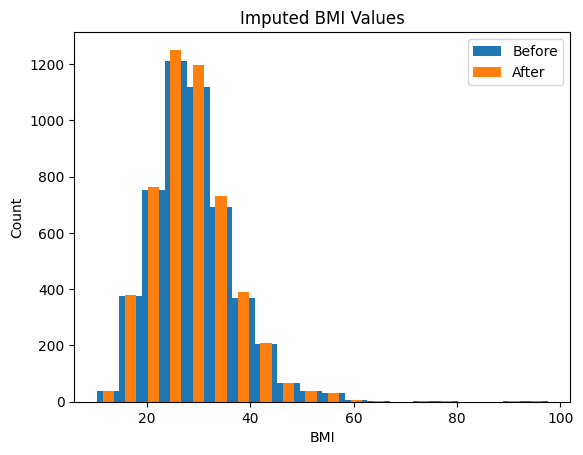

In [4]:
dataset_numeric = dataset.copy(deep=True)

category_maps = {}
# Convert categorical values to numeric
for c in ["gender", "ever_married", "work_type", "residence_type", "smoking_status"]:
    category_maps[c] = categorical_to_numeric(dataset_numeric, c)

plt.hist(dataset_numeric['bmi'], 20)

# Impute the missing values for BMI using KNN
dataset_numeric[dataset_numeric.columns] = KNNImputer().fit_transform(dataset_numeric.values)

plt.hist(dataset_numeric['bmi'], 20, rwidth=0.5)
plt.title('Imputed BMI Values')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.legend(['Before', 'After'])
plt.show()

After imputing the missing values for BMI and reviewing its distribution, it's clear that there are outliers, which can be addressed using Winsorization. The threshold is set to three standard deviations above the mean.

BMI Cutoff Value: 52.30
Observations Affected: 59 (1.15%)


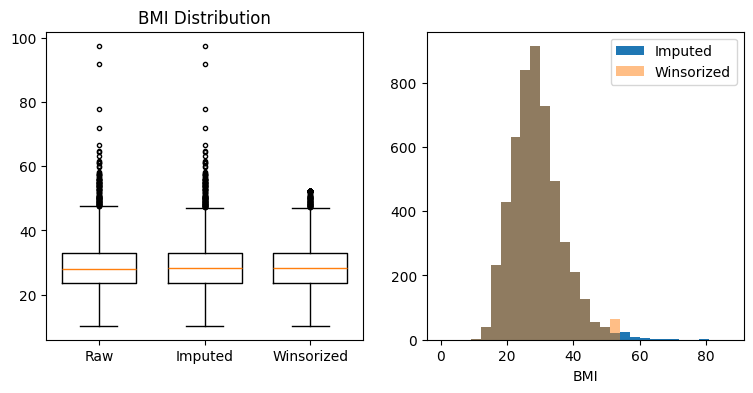

In [5]:
win_bmi = dataset_numeric['bmi'].copy(deep=True)
BMI_max_z = 3
mean = dataset_numeric['bmi'].mean()
std = dataset_numeric['bmi'].std()
indexes = (dataset_numeric['bmi']-mean)/std > BMI_max_z
cutoff = np.min(dataset_numeric["bmi"][indexes])
win_bmi[indexes] = cutoff

print(f"BMI Cutoff Value: {cutoff:.2f}")
print(f"Observations Affected: {sum(indexes)} ({sum(indexes)/len(win_bmi):.2%})")

fig, ax = plt.subplots(1, 2)
axs = fig.axes
fig.set_size_inches(9, 4)

axs[0].boxplot([dataset['bmi'].dropna(), dataset_numeric['bmi'], win_bmi], 
            tick_labels=['Raw', 'Imputed', 'Winsorized'],
            widths=0.7,
            flierprops={'markersize': 3})
axs[0].set_title('BMI Distribution')

bins = [i*3 for i in range(30)]
axs[1].hist(dataset_numeric['bmi'], bins)
axs[1].hist(win_bmi, bins, alpha=0.5)
axs[1].set_xlabel('BMI')
plt.legend(['Imputed', 'Winsorized'])

plt.show()

In [6]:
dataset_onehot = dataset.copy(deep=True)
# Convert categorical values to one-hot binary columns
for c in ["gender", "ever_married", "work_type", "residence_type", "smoking_status"]:
    categorical_to_columns(dataset_onehot, c)

# Impute the missing values for BMI using KNN
dataset_onehot[dataset_onehot.columns] = KNNImputer().fit_transform(dataset_onehot.values)

standardize_columns(dataset_onehot, ["age", "avg_glucose_level", "bmi"])

# Create a version of the numeric dataset with standardized columns
dataset_std = dataset_numeric.copy(deep=True)
standardize_columns(dataset_std, [c for c in dataset.columns if c != 'stroke'])

# Apply Winsorization to each dataset
dataset_numeric.loc[indexes, 'bmi'] = cutoff
dataset_std.loc[indexes, 'bmi'] = BMI_max_z
dataset_onehot.loc[indexes, 'bmi'] = BMI_max_z

print("\n> Post Cleaning (numeric)")
inspect_df(dataset_numeric)

print("\n> Post Cleaning (standardized)")
inspect_df(dataset_std)


> Post Cleaning (numeric)
age              : 0.080 to 82.000
avg_glucose_level: 55.120 to 271.740
bmi              : 10.300 to 52.300
ever_married     : 0.000 to 1.000
gender           : 0.000 to 1.000
heart_disease    : 0.000 to 1.000
hypertension     : 0.000 to 1.000
residence_type   : 0.000 to 1.000
smoking_status   : 0.000 to 3.000
stroke           : 0.000 to 1.000
work_type        : 0.000 to 4.000

> Post Cleaning (standardized)
age              : -1.908 to 1.715
avg_glucose_level: -1.127 to 3.657
bmi              : -2.401 to 3.000
ever_married     : -1.382 to 0.724
gender           : -0.840 to 1.190
heart_disease    : -0.239 to 4.185
hypertension     : -0.329 to 3.043
residence_type   : -1.016 to 0.984
smoking_status   : -1.285 to 1.515
stroke           : 0.000 to 1.000
work_type        : -1.988 to 1.681


In [7]:
print("\n> Post Cleaning (one-hot)")
inspect_df(dataset_onehot)


> Post Cleaning (one-hot)
age                           : -1.908 to 1.715
avg_glucose_level             : -1.127 to 3.657
bmi                           : -2.401 to 3.000
heart_disease                 : 0.000 to 1.000
hypertension                  : 0.000 to 1.000
stroke                        : 0.000 to 1.000
gender_Male                   : 0.000 to 1.000
ever_married_Yes              : 0.000 to 1.000
work_type_Private             : 0.000 to 1.000
work_type_Self-employed       : 0.000 to 1.000
work_type_Govt_job            : 0.000 to 1.000
work_type_children            : 0.000 to 1.000
residence_type_Urban          : 0.000 to 1.000
smoking_status_formerly smoked: 0.000 to 1.000
smoking_status_never smoked   : 0.000 to 1.000
smoking_status_smokes         : 0.000 to 1.000


### Sanity Check

We can perform an additional sanity check to ensure that the ranges we're seeing make sense. The binary and categorical features can be ignored, which leaves age, glucose level, and bmi.
1. Age: covers from infants to a feasible elderly age
2. Glucose level: Per [this article](https://my.clevelandclinic.org/health/diagnostics/12363-blood-glucose-test) normal blood glucose levels can range from approx. 50 to 100 mg/dL for individuals without diabetes, 100 to 125 mg/dL for those with pre-diabetes, and 125+ mg/dL for those with diabetes. [Another article](https://www.mayoclinic.org/diseases-conditions/diabetic-coma/symptoms-causes/syc-20371475) describes high levels of blood glucose up to 600 mg/dL being possible, but highly abnormal, so the 55 to 271 range in the dataset seems feasible.
3. BMI: per the [CDC website](https://www.cdc.gov/healthyweight/assessing/index.html) an adult BMI less than 18.5 is underweight while a BMI greater than 30 is obese. For reference, the required weight for a male of average height (5 foot, 7.5 inches) to reach our BMI min and max (10 to 98 before Winsorization) can be calculated, resulting in approximately 70 lbs and 630 lbs, respectively. Although they represent an underweight, or severely obese individual, these values are humanly possible.

### Pair Plot
Let's visualize the linear relationships and distributions of our features via a pair-plot:

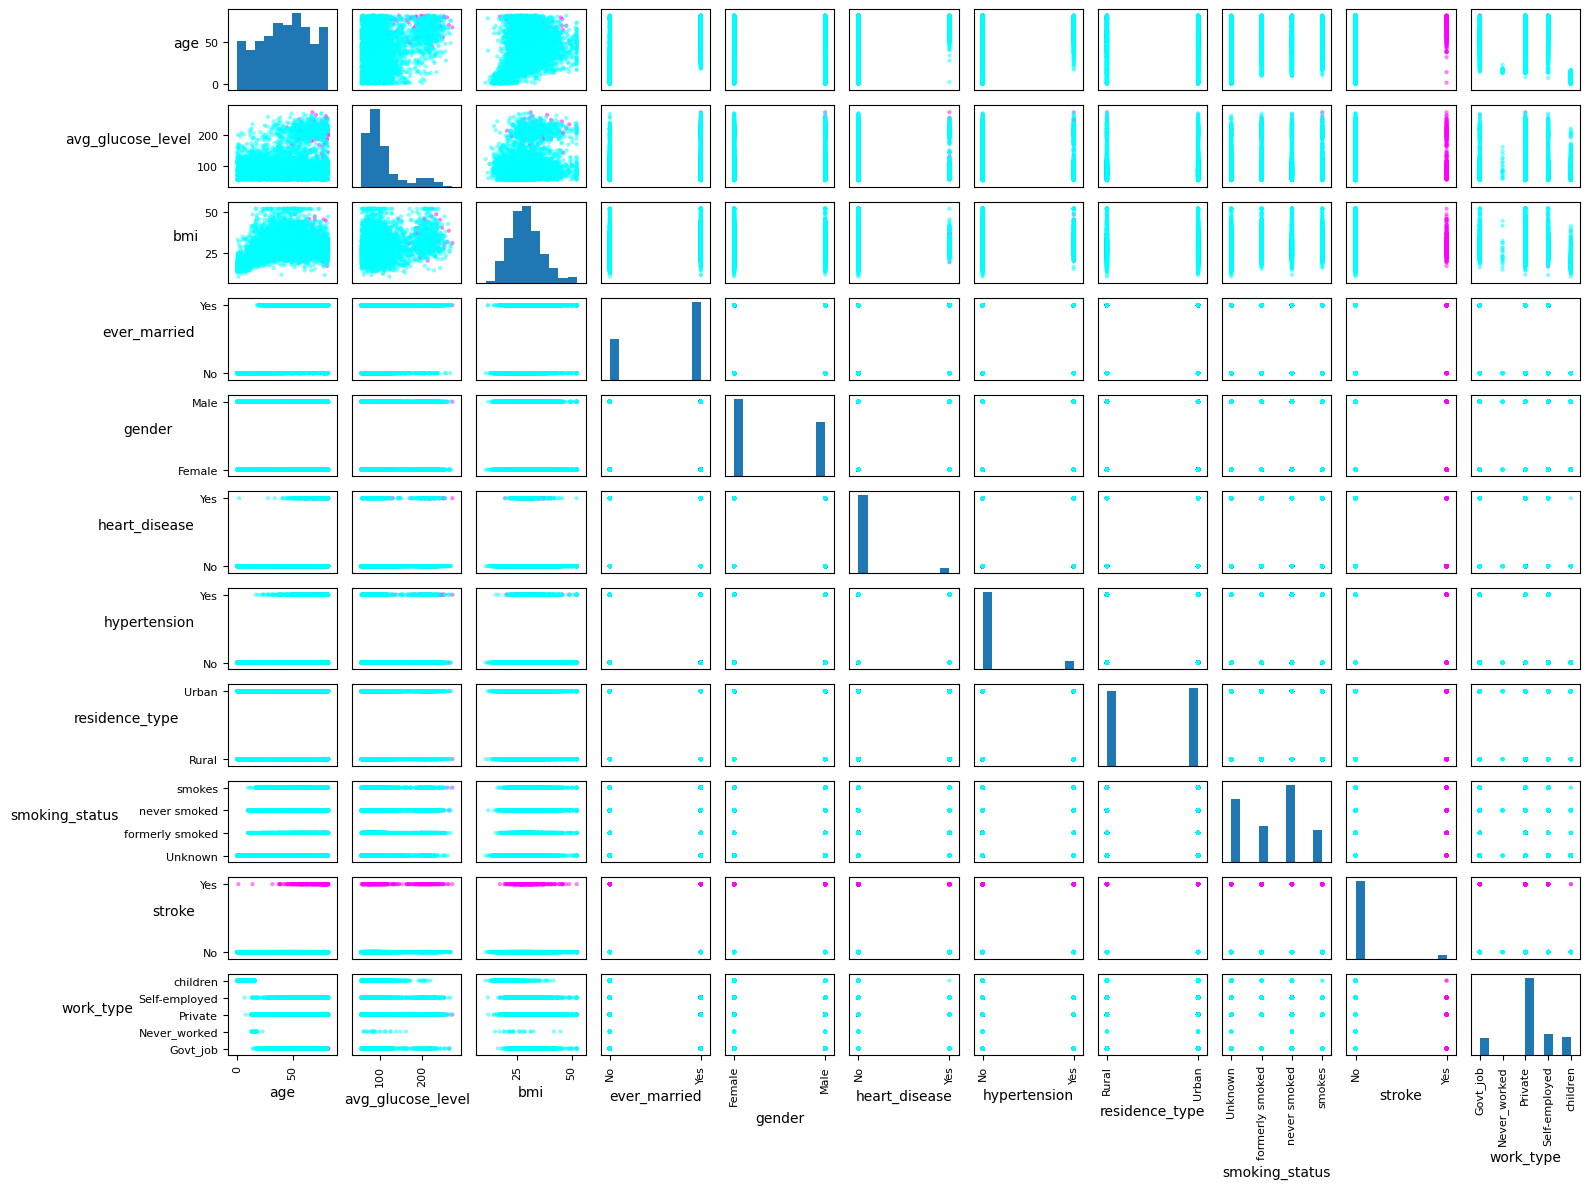

In [8]:
pair_plot(dataset_numeric, category_maps)

From the pair plot we can see that there are relatively few observations of strokes, hypertension, heart disease, and individuals that have never worked. In general, unbalanced observations make training more difficult as the model has fewer contrasting examples to fit to. In the case of our target feature (stroke) it creates an additional challenge during training, since it's possible for a model to achieve high accuracy by always predicting the most frequent observation (always predicting no stroke in this case).

Two strategies will be used to counteract this:
1. Training data will be re-sampled (with replacement) so that there are equal numbers of stroke and no stroke observations.
2. Models will be trained using the F1-Score as their performance metric instead of accuracy, which heavily penalizes the trivial "always pick no stroke" solution.

Additional Observations:
- From the plot we can see that almost all strokes were observed with individuals over approximately 40 years old, suggesting that age might be a good predictor. 
- Strokes, heart_disease, and ever_married have similar looking distributions over age, suggesting they may be highly correlated.
- There is also a large number of individuals with high (greater than approximately 125 mg/dL) glucose levels, suggesting that a significant portion of the dataset includes diabetics. 
- There are two distinct humps in the distribution of the glucose levels, which raises questions about the uniformity of the data gathering process (was some sub-group, such as diabetics, sampled more frequently?).

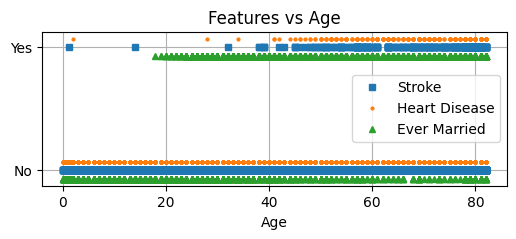

In [9]:
plt.plot(dataset_numeric['age'], dataset_numeric['stroke'], 's', markersize=4)
plt.plot(dataset_numeric['age'], dataset_numeric['heart_disease']+0.07, '.', markersize=4)
plt.plot(dataset_numeric['age'], dataset_numeric['ever_married']-0.07, '^', markersize=4)
plt.xlabel('Age')
plt.legend(['Stroke', 'Heart Disease', 'Ever Married'])
plt.gca().set_yticks([0, 1])
plt.gca().set_yticklabels(["No", "Yes"])
plt.title('Features vs Age')
plt.grid()
plt.gcf().set_size_inches(6, 2)
plt.show()

This plot more clearly shows the observations from the pair plots where certain features had similar distributions over age. By itself this is not enough information to determine if the corellation between features is significant/problematic, but points us to relationships worth further analysis.

### Evaluating Correlation

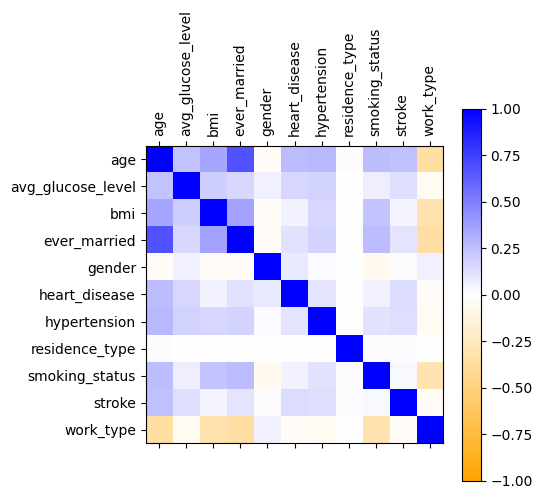

                    age  avg_glucose_level   bmi  ever_married  gender  \
age                1.00               0.24  0.35          0.68   -0.03   
avg_glucose_level  0.24               1.00  0.19          0.16    0.05   
bmi                0.35               0.19  1.00          0.35   -0.03   
ever_married       0.68               0.16  0.35          1.00   -0.03   
gender            -0.03               0.05 -0.03         -0.03    1.00   
heart_disease      0.26               0.16  0.05          0.11    0.09   
hypertension       0.28               0.17  0.16          0.16    0.02   
residence_type     0.01              -0.00 -0.00          0.01   -0.01   
smoking_status     0.27               0.06  0.23          0.26   -0.06   
stroke             0.25               0.13  0.04          0.11    0.01   
work_type         -0.36              -0.05 -0.31         -0.35    0.06   

                   heart_disease  hypertension  residence_type  \
age                         0.26          0.2

In [10]:
cmap = LinearSegmentedColormap.from_list('custom', ['orange', 'white', 'blue'])

correlations = dataset_std.corr()
labels = dataset_std.columns
plt.matshow(correlations, cmap=cmap, vmin=-1, vmax=1)
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.yticks(ticks=range(len(labels)), labels=labels)
plt.colorbar()
plt.show()

print(correlations.round(2))

VIFs = np.linalg.inv(correlations.values).diagonal()
print()
print(pd.DataFrame(VIFs, index=labels, columns=['VIF']).round(2))


The correlation plot shows that the highest correlation is between age and ever_married (0.68). Intuitively this makes sense, since an older individual would have had more time/opportunities to be married, and per this [UN data](https://data.un.org/documentdata.aspx?id=336) most countries have a minimum marriage age, often near 18 years old (recall that the country of origin of our data was not disclosed). 

Earler we saw that strokes, heart disease, and ever_married had similar looking distributions over age, but the correlation matrix reveals only a relatively weak (0.26 or less) correlation between any of these features except age and ever_married.

There is no simple rule-of-thumb for whether a correlation coefficient is too high, so instead the Variance Inflation Factors (VIFs) are calculated. We can see that all VIFs are well below 5, suggesting that it is acceptable to keep all features in the model.

### Principal Component Analysis (PCA)
PCA can help us reduce the number of features for training our models, while also providing insight into which features are the most influential. Here the PCs are calculated and their explained variance tabulated, along with the feature coefficients.
Note that the standardized one-hot dataset is used to keep variances comparable between features.

    Explained Var  Cumulative EV    age  avg_glucose_level    bmi  \
1        0.338774       0.338774  0.649             -0.275 -0.580   
2        0.174617       0.513391  0.432              0.896  0.039   
3        0.134225       0.647616  0.523             -0.272  0.776   
4        0.064886       0.712502  0.041              0.014 -0.047   
5        0.058071       0.770572  0.070              0.008 -0.028   
6        0.051035       0.821607 -0.006              0.058 -0.001   
7        0.046673       0.868280  0.246             -0.133 -0.147   
8        0.032949       0.901229  0.077             -0.079  0.124   
9        0.028779       0.930008  0.072             -0.028 -0.124   
10       0.021594       0.951602  0.030             -0.019 -0.026   
11       0.016217       0.967819 -0.175              0.124  0.024   
12       0.014637       0.982455  0.003             -0.007 -0.013   
13       0.009309       0.991764  0.066             -0.023 -0.053   
14       0.008021       0.999785  

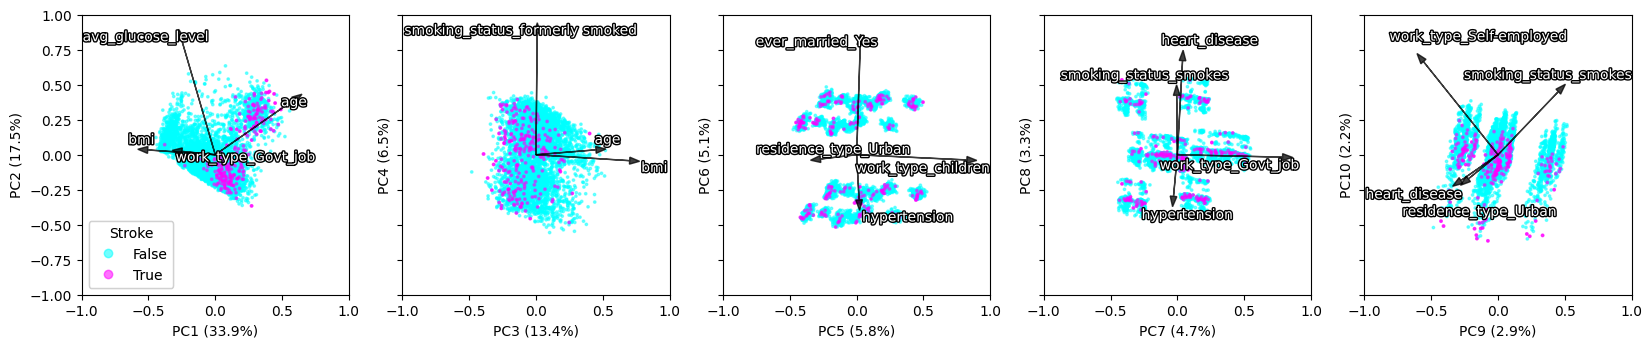

In [11]:
target_dataset = dataset_onehot
# Do not fit to the stroke column
subset = target_dataset[target_dataset.columns[target_dataset.columns != 'stroke']]
pca = PCA(random_state=RANDOM_SEED).fit(subset)

pca_df = pd.DataFrame({'Explained Var': pca.explained_variance_ratio_, 'Cumulative EV': np.cumsum(pca.explained_variance_ratio_)}, index=list(range(1, len(target_dataset.columns))))
for i, c in enumerate(subset.columns):
    pca_df[c] = np.round(pca.components_[i], 3)

print(pca_df)

y_data = target_dataset['stroke']
x_data = target_dataset.drop(columns=['stroke'])
x_new = pca.transform(x_data)

PCA_plot(x_new, y_data, pca.components_.T, labels=subset.columns, importance=pca.explained_variance_ratio_, pairs=5, thr=0.3, legend_loc='lower left')
plt.show()

Per the table, approximately 95% explained variance is reached with ten PCs, allowing the dimensionality of the problem to be reduced by five with only a small (5%) loss of information.


(Features whose coefficients have a magnitude less than 0.3 are omitted from the plots for clarity)

In [12]:
# Re-fit PCA with reduced number of components
N = 10
labels = 'ABCDEFGHIJKLMNOPQRTYUVWXYZ'
pca = PCA(N, random_state=RANDOM_SEED).fit(subset)
x_new = pca.transform(x_data)
pca_df = pd.DataFrame({'Explained Var': pca.explained_variance_ratio_, 'Cumulative EV': np.cumsum(pca.explained_variance_ratio_)})

# Further analysis expects a dataframe format
dataset_pca = pd.DataFrame(x_new, columns=[labels[i] for i in range(N)])
dataset_pca['stroke'] = y_data.values
print("> Data Transformed via PCA")
inspect_df(dataset_pca)

> Data Transformed via PCA
A     : -3.076 to 3.857
B     : -1.976 to 3.432
C     : -2.922 to 3.157
D     : -1.457 to 1.163
E     : -1.093 to 1.209
F     : -0.768 to 0.721
G     : -0.838 to 1.016
H     : -0.876 to 1.051
I     : -1.010 to 1.079
J     : -1.393 to 0.872
stroke: 0.000 to 1.000


### Model Training
There are two additional steps of data preparation before model training can begin:
1. Splitting data into testing and training sets
2. Re-sampling training data to balance stroke/no-stroke observations

These will be handled automatically by the custom GridSearch class, which will also perform K-fold cross validation during the search. 

Note that only the training data is re-sampled. Re-sampling the testing data would not provide new information and would skew the performance statistics (the models being used will always produce the same prediction for a given observation).

The models to be evaluated are:
- Support Vector Classifier (SVC)
- K-Nearest Neighbors (KNN)
- AdaBoostClassifier
- RandomForest
- LogisticRegression

The models will be evaluated on the PCA transformed data (PCA), the one-hot encoded data (OH), and the standardized data (STD).

In [13]:
# Track model performance
model_dict = {}
dsets = {"PCA": dataset_pca, 'OH': dataset_onehot, 'STD': dataset_std}

Grid search plots and confusion matrices can be generated via the "plot_search_grid" and "plot_confusion_matrix" functions of the GridSearch class, but have been omitted for brevity.

#### Note
Running all of the grid search iterations can take ~10 minutes collectively, or longer on a slower computer.

In [14]:
param_gridSVC = {"C": 10.0 ** np.arange(-1, 4), "gamma": 10.0 ** np.arange(-4, 1)}
for k, v in dsets.items():
    print('Evaluating:', k)
    gridSVC = GridSearch(v, param_gridSVC, svm.SVC(random_state=RANDOM_SEED), random_seed=RANDOM_SEED)
    gridSVC.eval(f'SVC_{k}', model_dict, plot_confusion=False, verbose=False)

Evaluating: PCA
Evaluating: OH
Evaluating: STD


In [15]:
param_gridKNN = {"n_neighbors": np.arange(1, 40, 4), "weights": ["uniform", "distance"]}
for k, v in dsets.items():
    print('Evaluating:', k)
    gridKNN = GridSearch(v, param_gridKNN, KNeighborsClassifier(), random_seed=RANDOM_SEED)
    gridKNN.eval(f'KNN_{k}', model_dict, plot_confusion=False, verbose=False)

Evaluating: PCA
Evaluating: OH
Evaluating: STD


In [16]:
param_gridADA = {
    "estimator": [DecisionTreeClassifier(max_depth=n) for n in range(2, 10)],
    "n_estimators": [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
}
for k, v in dsets.items():
    print('Evaluating:', k)
    gridADA = GridSearch(v, param_gridADA, AdaBoostClassifier(algorithm="SAMME", random_state=RANDOM_SEED), random_seed=RANDOM_SEED)
    gridADA.eval(f'AdaBoost_{k}', model_dict, plot_confusion=False, verbose=False)

Evaluating: PCA
Evaluating: OH
Evaluating: STD


In [17]:
param_gridForest = {
    "n_estimators": [1, 2, 4, 6, 8, 10, 12, 14, 16],
    "max_depth": [1, 2, 4, 6, 8, 10, 12, 14, 16],
}
for k, v in dsets.items():
    print('Evaluating:', k)
    gridForest = GridSearch(v, param_gridForest, RandomForestClassifier(random_state=RANDOM_SEED), random_seed=RANDOM_SEED)
    gridForest.eval(f'RandomForest_{k}', model_dict, plot_confusion=False, verbose=False)

Evaluating: PCA
Evaluating: OH
Evaluating: STD


In [18]:
param_gridLR = {
    "C": 10.0 ** np.arange(-5, 5),
    "solver": ['lbfgs', 'liblinear', 'newton-cg'],
}
for k, v in dsets.items():
    print('Evaluating:', k)
    gridLR = GridSearch(v, param_gridLR, LogisticRegression(random_state=RANDOM_SEED), random_seed=RANDOM_SEED)
    gridLR.eval(f'LogisticRegression_{k}', model_dict, plot_confusion=False, verbose=False)

Evaluating: PCA
Evaluating: OH
Evaluating: STD


An example of the grid search performed for the RandomForest model and PCA transformed dataset is shown below. It's clear that the training and testing scores are not maximized by the same parameters, which is expected.

The high scores will vary between these plots and the summary table since the grid search uses k-fold cross-validation and the final evaluation re-trains on a simple 80:20 training:testing split, with the best parameters.

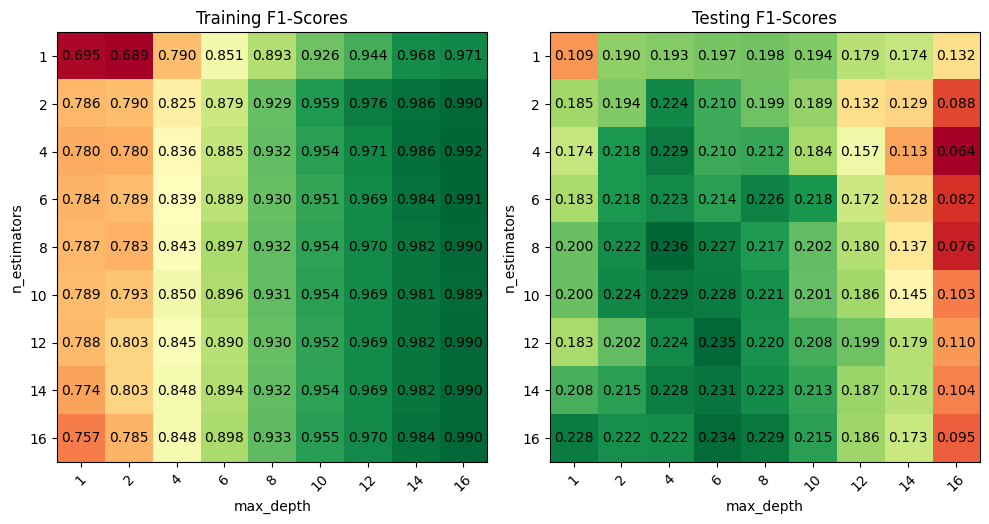

In [19]:
model_dict['RandomForest_PCA']['model'].plot_search_grid((10, 10))

### Models Summary
The results from evaluating the models optimized via grid search are shown in the table below. Scores are retrieved using the set of parameters that maximized the test score.

In [20]:
model_stats = pd.DataFrame(model_dict).T.sort_values(by=['test'], ascending=False)
print(model_stats.drop(columns=['model']).astype(float).round(3))

                        train   test  precision  recall     time
RandomForest_PCA        0.842  0.300      0.179   0.917   12.123
AdaBoost_OH             0.818  0.294      0.177   0.883   20.214
LogisticRegression_OH   0.776  0.283      0.168   0.883    1.653
SVC_PCA                 0.778  0.282      0.167   0.900  156.374
SVC_OH                  0.772  0.280      0.166   0.900  158.380
SVC_STD                 0.605  0.280      0.188   0.550  150.176
LogisticRegression_PCA  0.774  0.278      0.166   0.867    1.181
AdaBoost_STD            0.804  0.267      0.161   0.783   18.748
LogisticRegression_STD  0.776  0.262      0.156   0.817    1.206
RandomForest_OH         0.843  0.251      0.154   0.667    6.201
AdaBoost_PCA            0.836  0.239      0.141   0.783   52.197
KNN_PCA                 0.891  0.235      0.142   0.667   16.037
RandomForest_STD        0.961  0.214      0.157   0.333    6.681
KNN_OH                  1.000  0.206      0.135   0.433   21.560
KNN_STD                 1

We can see that the Random Forest using the PCA dataset achieved the highest F1-Score during testing (30%). Note that the ranking of the models tends to change between runs when the random seed is changed.

All models had relatively high recall compared to their precision, indicating a tendency to predict false-positives. Since our goal is to predict which patients are likely to have strokes it's preferred to err on the side of caution, so false-positives are preferred over false-negatives. If we look for the model with highest recall (most false-positives), then we again find the Random Forest with the PCA dataset performed the best.

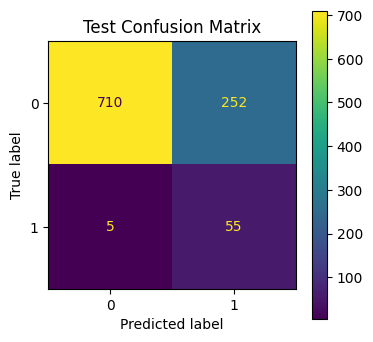

In [21]:
model_stats.at['RandomForest_PCA', 'model'].plot_confusion_matrix()

### Model Ensembles
Using an ensemble of our models may improve performance over the individual models. 

Ensembles are evaluated by calculating the performance metrics of each unique combination of trained models for that ensemble size. For example, an ensemble size of three requires "15 choose 3", or 455 evaluations. The results are divided into two groups: the ensemble that maximizes the F1-Score, and the ensemble that maximizes the recall.

In [22]:
df_f1, df_recall = model_ensembles(model_stats['model'].values, range(2, 10))

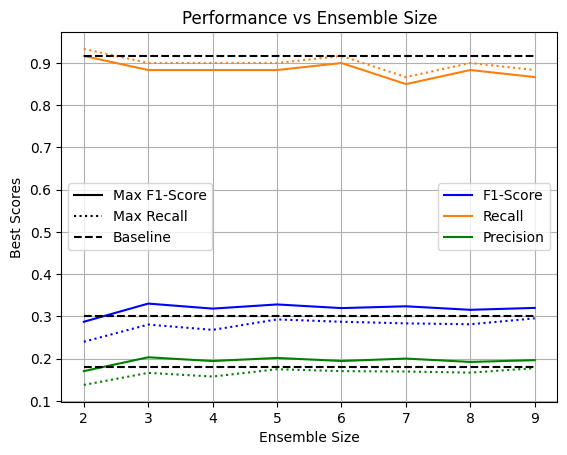

In [23]:
plot_ensembles(df_f1, df_recall, model_stats.loc['RandomForest_PCA', ['test', 'precision', 'recall']])

In [24]:
print("> Ensembles that Maximize F1-Score")
tmp = df_f1.drop(columns=["cm", 'idx']).astype("float").round(3)
tmp['idx'] = df_f1['idx']
print(tmp)
print("\n> Ensembles that Maximize Recall")
tmp = df_recall.drop(columns=["cm", 'idx']).astype("float").round(3)
tmp['idx'] = df_recall['idx']
print(tmp)

> Ensembles that Maximize F1-Score
      f1    rec   prec                              idx
2  0.287  0.917  0.170                          (0, 12)
3  0.330  0.883  0.203                       (0, 1, 13)
4  0.318  0.883  0.194                   (0, 1, 12, 13)
5  0.328  0.883  0.202                (0, 1, 5, 10, 13)
6  0.320  0.900  0.194            (0, 1, 5, 10, 12, 13)
7  0.324  0.850  0.200         (0, 1, 5, 6, 10, 12, 13)
8  0.315  0.883  0.192     (0, 1, 3, 5, 10, 11, 12, 13)
9  0.320  0.867  0.196  (0, 1, 3, 5, 6, 10, 11, 12, 13)

> Ensembles that Maximize Recall
      f1    rec   prec                              idx
2  0.240  0.933  0.138                          (6, 10)
3  0.281  0.900  0.166                       (4, 6, 10)
4  0.268  0.900  0.157                   (7, 8, 10, 13)
5  0.293  0.900  0.175                (4, 6, 7, 10, 13)
6  0.287  0.917  0.170            (3, 4, 5, 10, 13, 14)
7  0.283  0.867  0.169         (4, 6, 7, 8, 10, 13, 14)
8  0.281  0.900  0.167     (3, 4, 7

We can see that the ensemble with the highest F1-Score is size three

['RandomForest_PCA', 'AdaBoost_OH', 'KNN_OH']


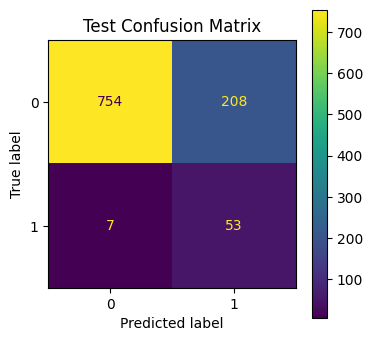

In [25]:
print([model_stats.index[i] for i in df_f1.at[3, 'idx']])

cm_plot = ConfusionMatrixDisplay(df_f1.at[3, 'cm'])
cm_plot.plot()
plt.gcf().set_size_inches(4, 4)
plt.title("Test Confusion Matrix")
plt.show()

['LogisticRegression_PCA', 'AdaBoost_PCA']


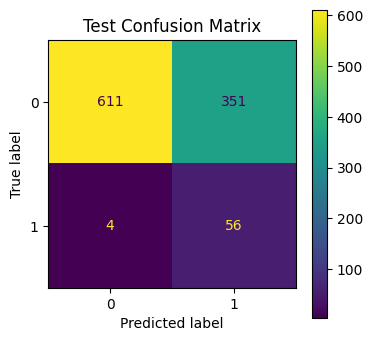

In [26]:
print([model_stats.index[i] for i in df_recall.at[2, 'idx']])

cm_plot = ConfusionMatrixDisplay(df_recall.at[2, 'cm'])
cm_plot.plot()
plt.gcf().set_size_inches(4, 4)
plt.title("Test Confusion Matrix")
plt.show()

### Conclusion
The goal of this project was to create models capable of accurately predicting which patients in the dataset were at risk of strokes. This goal was achieved through a process of data cleaning and preparation, followed by model selection, optimization, evaluation, and ensembling. 

Three methods of data preparation were considered; using PCA to perform dimensionality reduction, using standardized data, and using one-hot encoded data. Models trained on the one-hot encoded data had the highest F1-Scores when predicting on testing data, though there were other models with better recall. Since the consequences of false-negatives could be harmful in a medical setting, it was determined that models with higher false-positive rates were preferable (associated with higher recall).

Overall, three models were selected for further consideration depending on the requirements of their specific appliction (tradeoffs of precision and recall):
- RandomForest trained on one-hot encoded data
- SVC trained on one-hot encoded data
- An ensemble of the top three models (RandomForest, AdaBoost, and LogisticRegression, each trained on one-hot encoded data)

Future development on this subject could explore additional methods of ensembling models, additional types of models (e.g. neural networks), and additional methods of data preparation.